# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
import helpers

from visualization import scatter_pred_vs_true, plot_validation_performance

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Hack to find the conda activate path since bash scripts
# # don't necessarily work with the conda activate command
# conda_path = !which conda
# conda_path = list(conda_path)[0]
# conda_activate_path = pathlib.Path(conda_path).parent.parent / "bin" / "activate"
# if not conda_activate_path.is_file():
#     raise FileNotFoundError(
#         "Could not find your conda activate path needed for running bash scripts."
#     )

<IPython.core.display.Javascript object>

In [3]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_and_parse_pdbs_for_cavity_model.sh $conda_activate_path data/pdbids_2336.txt

<IPython.core.display.Javascript object>

Global variables

In [4]:
# Main parameters
WARM_START = "cavity_models/model_epoch_00.pt"
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
SHUFFLE_PDBS = True
LEARNING_RATE = 3e-4
EPOCHS = 2
PATIENCE_CUTOFF = 0
EPS = 1e-9

# Parameters for simulation stride
STRIDE_FRAGMENTS = 10
STRIDE_MD = 40

# Parameters specific to downstream model
BATCH_SIZE_DDG = 40
SHUFFLE_DDG = True
LEARNING_RATE_DDG = 1e-3
EPOCHS_DDG = 100

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [5]:
if WARM_START is None:
    parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
    if SHUFFLE_PDBS:
        random.shuffle(parsed_pdb_filenames)
    (
        dataloader_train,
        dataset_train,
        dataloader_val,
        dataset_val,
    ) = helpers.train_val_split(
        parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_00.pt


<IPython.core.display.Javascript object>

Train the cavity model

In [6]:
if WARM_START is None:
    # Define model
    cavity_model_net = CavityModel(DEVICE).to(DEVICE)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

    # Create directory for model files
    models_dirpath = "cavity_models/"
    if not os.path.exists(models_dirpath):
        os.mkdir(models_dirpath)

    # Train loop
    best_model_path = helpers.train_loop(
        dataloader_train,
        dataloader_val,
        cavity_model_net,
        loss_function,
        optimizer,
        EPOCHS,
        PATIENCE_CUTOFF,
    )
else:
    print(f"Warm start: {WARM_START}")

Warm start: cavity_models/model_epoch_00.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [7]:
# # Parse PDBs for which we have ddG data
# !./get_and_parse_pdbs_for_dowstream_task.sh $conda_activate_path

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [8]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [9]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [10]:
helpers.populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [11]:
# Load best performing cavity model from previos training
if WARM_START:
    best_model_path = WARM_START

cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

helpers.populate_dfs_with_nlls_and_nlfs(
    ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS
)

<IPython.core.display.Javascript object>

## Results without downstream model

### Plot with PDB statistics

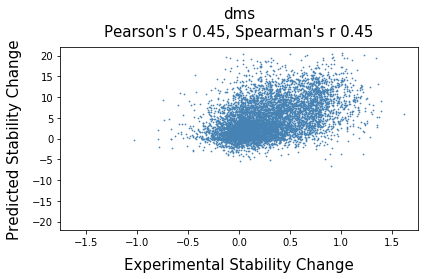

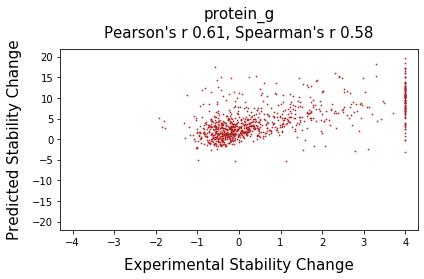

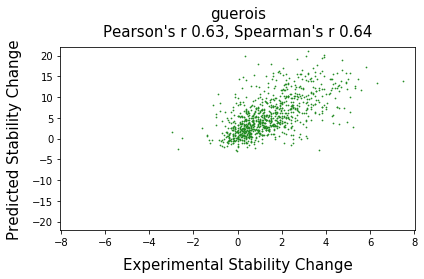

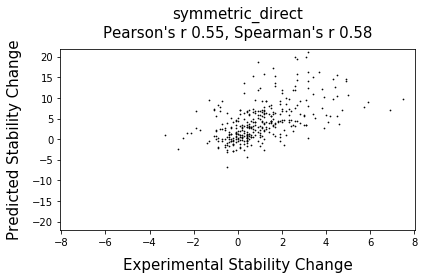

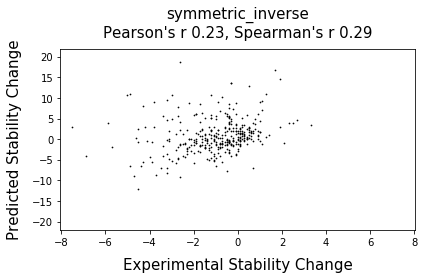

<IPython.core.display.Javascript object>

In [12]:
colors = ["steelblue", "firebrick", "forestgreen", "black", "black"]
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=color,
        title=data_key,
    )

### Plot with IDP statistics

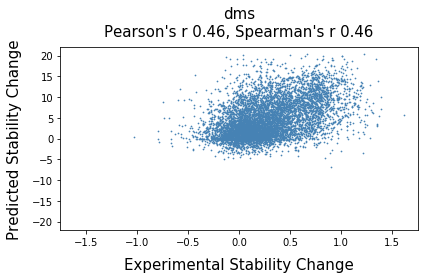

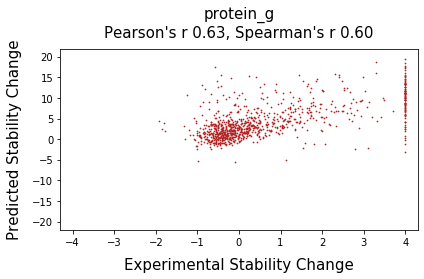

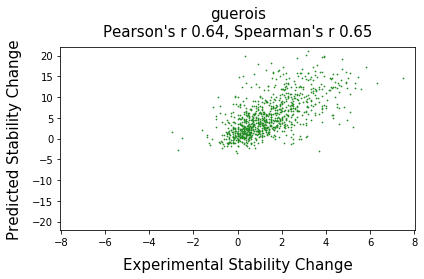

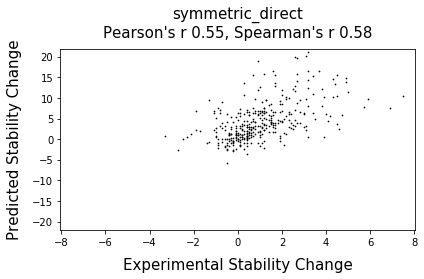

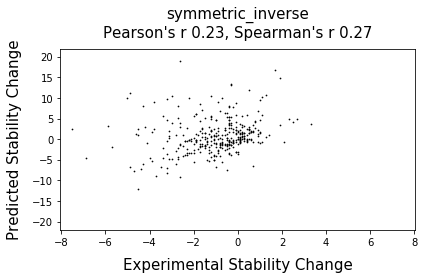

<IPython.core.display.Javascript object>

In [13]:
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_idp_no_ds"],
        color=color,
        title=data_key,
    )

Merge direct and inverse dfs

In [14]:
# Rename columns so they specify if it is the direct or inverse direction
symmetric_direct_df = ddg_data_dict["symmetric_direct"]
symmetric_direct_df.columns = [
    name + "_dir" if "_dir" not in name else name
    for name in symmetric_direct_df.columns
]
symmetric_inverse_df = ddg_data_dict["symmetric_inverse"]
symmetric_inverse_df.columns = [
    name + "_inv" if "_inv" not in name else name
    for name in symmetric_inverse_df.columns
]

# Inner merge both dataframes
ddg_data_dict["symmetric_both"] = pd.merge(
    symmetric_direct_df,
    symmetric_inverse_df,
    how="inner",
    left_on="merge_column_dir",
    right_on="merge_column_inv",
)

<IPython.core.display.Javascript object>

Make prediction based on both structures

In [15]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_dir"] - row["ddg_pred_no_ds_inv"]), axis=1
)
symmetric_both_df["ddg_pred_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_inv"] - row["ddg_pred_no_ds_dir"]), axis=1
)

<IPython.core.display.Javascript object>

In [16]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_idp_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_dir"] - row["ddg_pred_idp_no_ds_inv"]),
    axis=1,
)
symmetric_both_df["ddg_pred_idp_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_idp_no_ds_inv"] - row["ddg_pred_idp_no_ds_dir"]),
    axis=1,
)

<IPython.core.display.Javascript object>

### Plot prediction using both structures

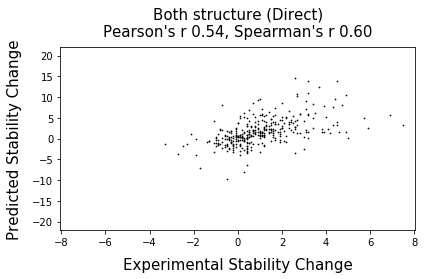

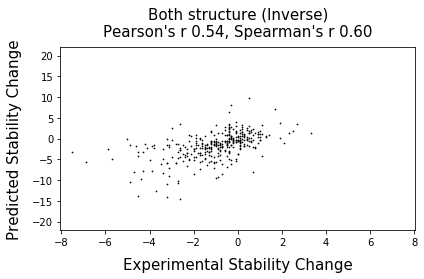

<IPython.core.display.Javascript object>

In [17]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Plot prediction using both structures (IDP statistics)

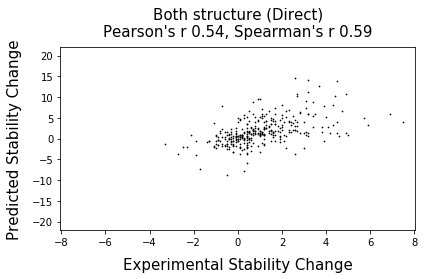

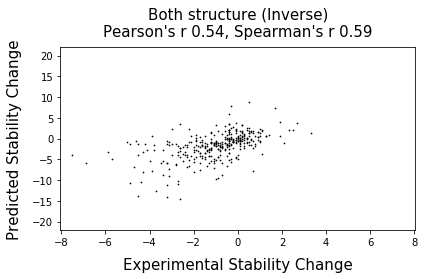

<IPython.core.display.Javascript object>

In [18]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_idp_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

### Phaistos statistics

In [19]:
# Add flanking sequence fragments for protein g
raw_pdbs = glob.glob("data/data_protein_g/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers.add_flanking_seq_fragments(
        ddg_data_dict,
        "protein_g",
        raw_pdb,
    )

# Add flanking sequence fragments for guerois
raw_pdbs = glob.glob("data/data_guerois/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers.add_flanking_seq_fragments(
        ddg_data_dict,
        "guerois",
        raw_pdb,
    )

# Add flanking sequence fragments for dms
raw_pdbs = glob.glob("data/data_dms/pdbs_raw/*.pdb")
for raw_pdb in raw_pdbs:
    helpers.add_flanking_seq_fragments(
        ddg_data_dict,
        "dms",
        raw_pdb,
    )

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4562.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4563.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4564.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4565.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontin

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4264.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4334.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4385.
  PDBConstructionWarning)
/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4551.
  PDBConstructionWarning)


<IPython.core.display.Javascript object>

In [20]:
# Output CSVs (So Wouter can simulate them)
ddg_data_dict["protein_g"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_protein_g/sequence_flanks_protein_g.csv")
ddg_data_dict["dms"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_dms/sequence_flanks_dms.csv")
ddg_data_dict["guerois"][
    ["pdbid", "variant", "left_flank", "right_flank", "wt_restype", "mt_restype"]
].to_csv("data/data_guerois/sequence_flanks_guerois.csv")

<IPython.core.display.Javascript object>

#### Protein G (phaistos statistics)

In [21]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["protein_g"] = ddg_data_dict["protein_g"].iloc[0:10]

<IPython.core.display.Javascript object>

0 1PGA
1 1PGA
2 1PGA
3 1PGA
4 1PGA
5 1PGA
6 1PGA
7 1PGA
8 1PGA
9 1PGA
10 1PGA
11 1PGA
12 1PGA
13 1PGA
14 1PGA
15 1PGA
16 1PGA
17 1PGA
18 1PGA
19 1PGA
20 1PGA
21 1PGA
22 1PGA
23 1PGA
24 1PGA
25 1PGA
26 1PGA
27 1PGA
28 1PGA
29 1PGA
30 1PGA
31 1PGA
32 1PGA
33 1PGA
34 1PGA
35 1PGA
36 1PGA
37 1PGA
38 1PGA
39 1PGA
40 1PGA
41 1PGA
42 1PGA
43 1PGA
44 1PGA
45 1PGA
46 1PGA
47 1PGA
48 1PGA
49 1PGA
50 1PGA
51 1PGA
52 1PGA
53 1PGA
54 1PGA
55 1PGA
56 1PGA
57 1PGA
58 1PGA
59 1PGA
60 1PGA
61 1PGA
62 1PGA
63 1PGA
64 1PGA
65 1PGA
66 1PGA
67 1PGA
68 1PGA
69 1PGA
70 1PGA
71 1PGA
72 1PGA
73 1PGA
74 1PGA
75 1PGA
76 1PGA
77 1PGA
78 1PGA
79 1PGA
80 1PGA
81 1PGA
82 1PGA
83 1PGA
84 1PGA
85 1PGA
86 1PGA
87 1PGA
88 1PGA
89 1PGA
90 1PGA
91 1PGA
92 1PGA
93 1PGA
94 1PGA
95 1PGA
96 1PGA
97 1PGA
98 1PGA
99 1PGA
100 1PGA
101 1PGA
102 1PGA
103 1PGA
104 1PGA
105 1PGA
106 1PGA
107 1PGA
108 1PGA
109 1PGA
110 1PGA
111 1PGA
112 1PGA
113 1PGA
114 1PGA
115 1PGA
116 1PGA
117 1PGA
118 1PGA
119 1PGA
120 1PGA
121 1PGA
122 1PGA
123

20 1PGA
21 1PGA
22 1PGA
23 1PGA
24 1PGA
25 1PGA
26 1PGA
27 1PGA
28 1PGA
29 1PGA
30 1PGA
31 1PGA
32 1PGA
33 1PGA
34 1PGA
35 1PGA
36 1PGA
37 1PGA
38 1PGA
39 1PGA
40 1PGA
41 1PGA
42 1PGA
43 1PGA
44 1PGA
45 1PGA
46 1PGA
47 1PGA
48 1PGA
49 1PGA
50 1PGA
51 1PGA
52 1PGA
53 1PGA
54 1PGA
55 1PGA
56 1PGA
57 1PGA
58 1PGA
59 1PGA
60 1PGA
61 1PGA
62 1PGA
63 1PGA
64 1PGA
65 1PGA
66 1PGA
67 1PGA
68 1PGA
69 1PGA
70 1PGA
71 1PGA
72 1PGA
73 1PGA
74 1PGA
75 1PGA
76 1PGA
77 1PGA
78 1PGA
79 1PGA
80 1PGA
81 1PGA
82 1PGA
83 1PGA
84 1PGA
85 1PGA
86 1PGA
87 1PGA
88 1PGA
89 1PGA
90 1PGA
91 1PGA
92 1PGA
93 1PGA
94 1PGA
95 1PGA
96 1PGA
97 1PGA
98 1PGA
99 1PGA
100 1PGA
101 1PGA
102 1PGA
103 1PGA
104 1PGA
105 1PGA
106 1PGA
107 1PGA
108 1PGA
109 1PGA
110 1PGA
111 1PGA
112 1PGA
113 1PGA
114 1PGA
115 1PGA
116 1PGA
117 1PGA
118 1PGA
119 1PGA
120 1PGA
121 1PGA
122 1PGA
123 1PGA
124 1PGA
125 1PGA
126 1PGA
127 1PGA
128 1PGA
129 1PGA
130 1PGA
131 1PGA
132 1PGA
133 1PGA
134 1PGA
135 1PGA
136 1PGA
137 1PGA
138 1PGA
139 1PGA


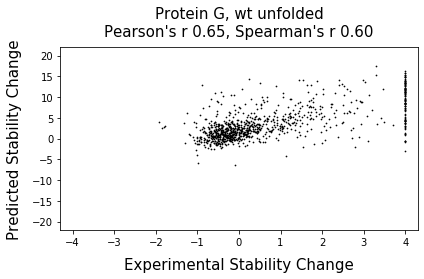

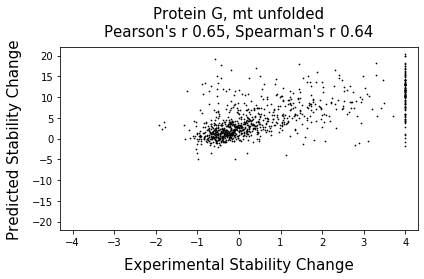

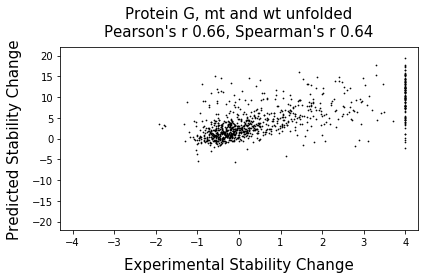

<IPython.core.display.Javascript object>

In [22]:
data_set = "protein_g"
data_set_title = "Protein G"

helpers.infer_probabilities_for_center_residues(
    ddg_data_dict,
    data_set,
    cavity_model_infer_net,
    DEVICE,
    EPS,
    is_wt=True,
    stride=STRIDE_FRAGMENTS,
)
helpers.infer_probabilities_for_center_residues(
    ddg_data_dict,
    data_set,
    cavity_model_infer_net,
    DEVICE,
    EPS,
    is_wt=False,
    stride=STRIDE_FRAGMENTS,
)
helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

#### Guerois (Phaistos statistics)

In [23]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["guerois"] = ddg_data_dict["guerois"].iloc[0:10]

<IPython.core.display.Javascript object>

0 171L
1 1A2P
2 1A2P
3 1A2P
4 1A2P
5 1A2P
6 1A2P
7 1A2P
8 1A2P
9 1A2P
10 1A2P
11 1A2P
12 1A2P
13 1A2P
14 1A2P
15 1A2P
16 1A2P
17 1A2P
18 1A2P
19 1A2P
20 1A2P
21 1A2P
22 1A2P
23 1A2P
24 1A2P
25 1A2P
26 1A2P
27 1A2P
28 1A2P
29 1A2P
30 1A2P
31 1A2P
32 1A2P
33 1A2P
34 1A2P
35 1A2P
36 1A2P
37 1A2P
38 1A2P
39 1A2P
40 1A2P
41 1A2P
42 1A2P
43 1A2P
44 1A2P
45 1A2P
46 1A2P
47 1A2P
48 1A2P
49 1A2P
50 1A2P
51 1A2P
52 1A2P
53 1A2P
54 1A2P
55 1A2P
56 1A2P
57 1A2P
58 1A2P
59 1A2P
60 1A2P
61 1A2P
62 1A2P
63 1A2P
64 1ANF
65 1ANF
66 1ANF
67 1ANF
68 1BF4
69 1BF4
70 1BF4
71 1BF4
72 1BF4
73 1BF4
74 1BF4
75 1BF4
76 1BF4
77 1BF4
78 1BF4
79 1BF4
80 1BF4
81 1BF4
82 1BF4
83 1BF4
84 1BF4
85 1BF4
86 1BPI
87 1BPI
88 1BPI
89 1BPI
90 1BPI
91 1BPI
92 1BPI
93 1BPI
94 1BPI
95 1BPI
96 1BPI
97 1BPI
98 1BPI
99 1BPI
100 1BPI
101 1BPI
102 1BPI
103 1BPI
104 1BPI
105 1BPI
106 1BPI
107 1BPI
108 1BPI
109 1BPI
110 1BPI
111 1BPI
112 1BPI
113 1BPI
114 1BPI
115 1BPI
116 1BPI
117 1BPI
118 1BPI
119 1BPI
120 1BPI
121 1BVC
122 1BVC
123

23 1A2P
24 1A2P
25 1A2P
26 1A2P
27 1A2P
28 1A2P
29 1A2P
30 1A2P
31 1A2P
32 1A2P
33 1A2P
34 1A2P
35 1A2P
36 1A2P
37 1A2P
38 1A2P
39 1A2P
40 1A2P
41 1A2P
42 1A2P
43 1A2P
44 1A2P
45 1A2P
46 1A2P
47 1A2P
48 1A2P
49 1A2P
50 1A2P
51 1A2P
52 1A2P
53 1A2P
54 1A2P
55 1A2P
56 1A2P
57 1A2P
58 1A2P
59 1A2P
60 1A2P
61 1A2P
62 1A2P
63 1A2P
64 1ANF
65 1ANF
66 1ANF
67 1ANF
68 1BF4
69 1BF4
70 1BF4
71 1BF4
72 1BF4
73 1BF4
74 1BF4
75 1BF4
76 1BF4
77 1BF4
78 1BF4
79 1BF4
80 1BF4
81 1BF4
82 1BF4
83 1BF4
84 1BF4
85 1BF4
86 1BPI
87 1BPI
88 1BPI
89 1BPI
90 1BPI
91 1BPI
92 1BPI
93 1BPI
94 1BPI
95 1BPI
96 1BPI
97 1BPI
98 1BPI
99 1BPI
100 1BPI
101 1BPI
102 1BPI
103 1BPI
104 1BPI
105 1BPI
106 1BPI
107 1BPI
108 1BPI
109 1BPI
110 1BPI
111 1BPI
112 1BPI
113 1BPI
114 1BPI
115 1BPI
116 1BPI
117 1BPI
118 1BPI
119 1BPI
120 1BPI
121 1BVC
122 1BVC
123 1BVC
124 1CEY
125 1CEY
126 1CEY
127 1CEY
128 1CEY
129 1CEY
130 1CEY
131 1CEY
132 1CEY
133 1CEY
134 1CEY
135 1CEY
136 1CEY
137 1CEY
138 1CSP
139 1CSP
140 1CSP
141 1CSP
142 1C

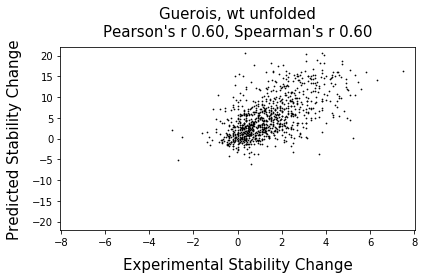

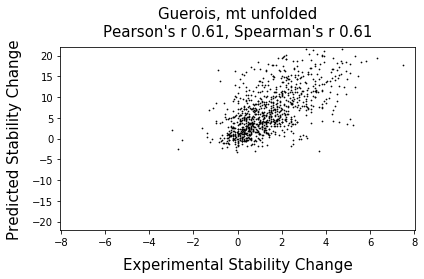

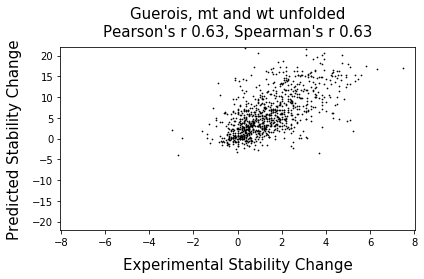

<IPython.core.display.Javascript object>

In [24]:
data_set = "guerois"
data_set_title = "Guerois"

helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

#### DMS (Phaistos statistics)

In [25]:
# # DROP SOME ROWS FOR QUICKER TESTING
# ddg_data_dict["dms"] = ddg_data_dict["dms"].iloc[0:10]

<IPython.core.display.Javascript object>

120 1D5R
121 1D5R
122 1D5R
123 1D5R
124 1D5R
125 1D5R
126 1D5R
127 1D5R
128 1D5R
129 1D5R
130 1D5R
131 1D5R
132 1D5R
133 1D5R
134 1D5R
135 1D5R
136 1D5R
137 1D5R
138 1D5R
139 1D5R
140 1D5R
141 1D5R
142 1D5R
143 1D5R
144 1D5R
145 1D5R
146 1D5R
147 1D5R
148 1D5R
149 1D5R
150 1D5R
151 1D5R
152 1D5R
153 1D5R
154 1D5R
155 1D5R
156 1D5R
157 1D5R
158 1D5R
159 1D5R
160 1D5R
161 1D5R
162 1D5R
163 1D5R
164 1D5R
165 1D5R
166 1D5R
167 1D5R
168 1D5R
169 1D5R
170 1D5R
171 1D5R
172 1D5R
173 1D5R
174 1D5R
175 1D5R
176 1D5R
177 1D5R
178 1D5R
179 1D5R
180 1D5R
181 1D5R
182 1D5R
183 1D5R
184 1D5R
185 1D5R
186 1D5R
187 1D5R
188 1D5R
189 1D5R
190 1D5R
191 1D5R
192 1D5R
193 1D5R
194 1D5R
195 1D5R
196 1D5R
197 1D5R
198 1D5R
199 1D5R
200 1D5R
201 1D5R
202 1D5R
203 1D5R
204 1D5R
205 1D5R
206 1D5R
207 1D5R
208 1D5R
209 1D5R
210 1D5R
211 1D5R
212 1D5R
213 1D5R
214 1D5R
215 1D5R
216 1D5R
217 1D5R
218 1D5R
219 1D5R
220 1D5R
221 1D5R
222 1D5R
223 1D5R
224 1D5R
225 1D5R
226 1D5R
227 1D5R
228 1D5R
229 1D5R
230 1D5R
2

1033 1D5R
1034 1D5R
1035 1D5R
1036 1D5R
1037 1D5R
1038 1D5R
1039 1D5R
1040 1D5R
1041 1D5R
1042 1D5R
1043 1D5R
1044 1D5R
1045 1D5R
1046 1D5R
1047 1D5R
1048 1D5R
1049 1D5R
1050 1D5R
1051 1D5R
1052 1D5R
1053 1D5R
1054 1D5R
1055 1D5R
1056 1D5R
1057 1D5R
1058 1D5R
1059 1D5R
1060 1D5R
1061 1D5R
1062 1D5R
1063 1D5R
1064 1D5R
1065 1D5R
1066 1D5R
1067 1D5R
1068 1D5R
1069 1D5R
1070 1D5R
1071 1D5R
1072 1D5R
1073 1D5R
1074 1D5R
1075 1D5R
1076 1D5R
1077 1D5R
1078 1D5R
1079 1D5R
1080 1D5R
1081 1D5R
1082 1D5R
1083 1D5R
1084 1D5R
1085 1D5R
1086 1D5R
1087 1D5R
1088 1D5R
1089 1D5R
1090 1D5R
1091 1D5R
1092 1D5R
1093 1D5R
1094 1D5R
1095 1D5R
1096 1D5R
1097 1D5R
1098 1D5R
1099 1D5R
1100 1D5R
1101 1D5R
1102 1D5R
1103 1D5R
1104 1D5R
1105 1D5R
1106 1D5R
1107 1D5R
1108 1D5R
1109 1D5R
1110 1D5R
1111 1D5R
1112 1D5R
1113 1D5R
1114 1D5R
1115 1D5R
1116 1D5R
1117 1D5R
1118 1D5R
1119 1D5R
1120 1D5R
1121 1D5R
1122 1D5R
1123 1D5R
1124 1D5R
1125 1D5R
1126 1D5R
1127 1D5R
1128 1D5R
1129 1D5R
1130 1D5R
1131 1D5R
1132 1D5R


1857 1D5R
1858 1D5R
1859 1D5R
1860 1D5R
1861 1D5R
1862 1D5R
1863 1D5R
1864 1D5R
1865 1D5R
1866 1D5R
1867 1D5R
1868 1D5R
1869 1D5R
1870 1D5R
1871 1D5R
1872 1D5R
1873 1D5R
1874 1D5R
1875 1D5R
1876 1D5R
1877 1D5R
1878 1D5R
1879 1D5R
1880 1D5R
1881 1D5R
1882 1D5R
1883 1D5R
1884 1D5R
1885 1D5R
1886 1D5R
1887 1D5R
1888 1D5R
1889 1D5R
1890 1D5R
1891 1D5R
1892 1D5R
1893 1D5R
1894 1D5R
1895 1D5R
1896 1D5R
1897 1D5R
1898 1D5R
1899 1D5R
1900 1D5R
1901 1D5R
1902 1D5R
1903 1D5R
1904 1D5R
1905 1D5R
1906 1D5R
1907 1D5R
1908 1D5R
1909 1D5R
1910 1D5R
1911 1D5R
1912 1D5R
1913 1D5R
1914 1D5R
1915 1D5R
1916 1D5R
1917 1D5R
1918 1D5R
1919 1D5R
1920 1D5R
1921 1D5R
1922 1D5R
1923 1D5R
1924 1D5R
1925 1D5R
1926 1D5R
1927 1D5R
1928 1D5R
1929 1D5R
1930 1D5R
1931 1D5R
1932 1D5R
1933 1D5R
1934 1D5R
1935 1D5R
1936 1D5R
1937 1D5R
1938 1D5R
1939 1D5R
1940 1D5R
1941 1D5R
1942 1D5R
1943 1D5R
1944 1D5R
1945 1D5R
1946 1D5R
1947 1D5R
1948 1D5R
1949 1D5R
1950 1D5R
1951 1D5R
1952 1D5R
1953 1D5R
1954 1D5R
1955 1D5R
1956 1D5R


2687 1D5R
2688 1D5R
2689 1D5R
2690 1D5R
2691 1D5R
2692 1D5R
2693 1D5R
2694 1D5R
2695 1D5R
2696 1D5R
2697 1D5R
2698 1D5R
2699 1D5R
2700 1D5R
2701 1D5R
2702 1D5R
2703 1D5R
2704 1D5R
2705 1D5R
2706 1D5R
2707 1D5R
2708 1D5R
2709 1D5R
2710 1D5R
2711 1D5R
2712 1D5R
2713 1D5R
2714 1D5R
2715 1D5R
2716 1D5R
2717 1D5R
2718 1D5R
2719 1D5R
2720 1D5R
2721 1D5R
2722 1D5R
2723 1D5R
2724 1D5R
2725 1D5R
2726 1D5R
2727 1D5R
2728 1D5R
2729 1D5R
2730 1D5R
2731 1D5R
2732 1D5R
2733 1D5R
2734 1D5R
2735 1D5R
2736 1D5R
2737 1D5R
2738 1D5R
2739 1D5R
2740 1D5R
2741 1D5R
2742 1D5R
2743 1D5R
2744 1D5R
2745 1D5R
2746 1D5R
2747 1D5R
2748 1D5R
2749 1D5R
2750 1D5R
2751 1D5R
2752 1D5R
2753 1D5R
2754 1D5R
2755 1D5R
2756 1D5R
2757 1D5R
2758 1D5R
2759 1D5R
2760 1D5R
2761 1D5R
2762 1D5R
2763 1D5R
2764 1D5R
2765 1D5R
2766 1D5R
2767 1D5R
2768 1D5R
2769 1D5R
2770 1D5R
2771 1D5R
2772 1D5R
2773 1D5R
2774 1D5R
2775 1D5R
2776 1D5R
2777 1D5R
2778 1D5R
2779 1D5R
2780 1D5R
2781 1D5R
2782 1D5R
2783 1D5R
2784 1D5R
2785 1D5R
2786 1D5R


4576 2H11
4577 2H11
4578 2H11
4579 2H11
4580 2H11
4581 2H11
4582 2H11
4583 2H11
4584 2H11
4585 2H11
4586 2H11
4587 2H11
4588 2H11
4589 2H11
4590 2H11
4591 2H11
4592 2H11
4593 2H11
4594 2H11
4595 2H11
4596 2H11
4597 2H11
4598 2H11
4599 2H11
4600 2H11
4601 2H11
4602 2H11
4603 2H11
4604 2H11
4605 2H11
4606 2H11
4607 2H11
4608 2H11
4609 2H11
4610 2H11
4611 2H11
4612 2H11
4613 2H11
4614 2H11
4615 2H11
4616 2H11
4617 2H11
4618 2H11
4619 2H11
4620 2H11
4621 2H11
4622 2H11
4623 2H11
4624 2H11
4625 2H11
4626 2H11
4627 2H11
4628 2H11
4629 2H11
4630 2H11
4631 2H11
4632 2H11
4633 2H11
4634 2H11
4635 2H11
4636 2H11
4637 2H11
4638 2H11
4639 2H11
4640 2H11
4641 2H11
4642 2H11
4643 2H11
4644 2H11
4645 2H11
4646 2H11
4647 2H11
4648 2H11
4649 2H11
4650 2H11
4651 2H11
4652 2H11
4653 2H11
4654 2H11
4655 2H11
4656 2H11
4657 2H11
4658 2H11
4659 2H11
4660 2H11
4661 2H11
4662 2H11
4663 2H11
4664 2H11
4665 2H11
4666 2H11
4667 2H11
4668 2H11
4669 2H11
4670 2H11
4671 2H11
4672 2H11
4673 2H11
4674 2H11
4675 2H11


5398 2H11
5399 2H11
5400 2H11
5401 2H11
5402 2H11
5403 2H11
5404 2H11
5405 2H11
5406 2H11
5407 2H11
5408 2H11
5409 2H11
5410 2H11
5411 2H11
5412 2H11
5413 2H11
5414 2H11
5415 2H11
5416 2H11
5417 2H11
5418 2H11
5419 2H11
5420 2H11
5421 2H11
5422 2H11
5423 2H11
5424 2H11
5425 2H11
5426 2H11
5427 2H11
5428 2H11
5429 2H11
5430 2H11
5431 2H11
5432 2H11
5433 2H11
5434 2H11
5435 2H11
5436 2H11
5437 2H11
5438 2H11
5439 2H11
5440 2H11
5441 2H11
5442 2H11
5443 2H11
5444 2H11
5445 2H11
5446 2H11
5447 2H11
5448 2H11
5449 2H11
5450 2H11
5451 2H11
5452 2H11
5453 2H11
5454 2H11
5455 2H11
5456 2H11
5457 2H11
5458 2H11
5459 2H11
5460 2H11
5461 2H11
5462 2H11
5463 2H11
5464 2H11
5465 2H11
5466 2H11
5467 2H11
5468 2H11
5469 2H11
5470 2H11
5471 2H11
5472 2H11
5473 2H11
5474 2H11
5475 2H11
5476 2H11
5477 2H11
5478 2H11
5479 2H11
5480 2H11
5481 2H11
5482 2H11
5483 2H11
5484 2H11
5485 2H11
5486 2H11
5487 2H11
5488 2H11
5489 2H11
5490 2H11
5491 2H11
5492 2H11
5493 2H11
5494 2H11
5495 2H11
5496 2H11
5497 2H11


6226 2H11
6227 2H11
6228 2H11
6229 2H11
6230 2H11
6231 2H11
6232 2H11
6233 2H11
6234 2H11
6235 2H11
6236 2H11
6237 2H11
6238 2H11
6239 2H11
6240 2H11
6241 2H11
6242 2H11
6243 2H11
6244 2H11
6245 2H11
6246 2H11
6247 2H11
6248 2H11
6249 2H11
6250 2H11
6251 2H11
6252 2H11
6253 2H11
6254 2H11
6255 2H11
6256 2H11
6257 2H11
6258 2H11
6259 2H11
6260 2H11
6261 2H11
6262 2H11
6263 2H11
6264 2H11
6265 2H11
6266 2H11
6267 2H11
6268 2H11
6269 2H11
6270 2H11
6271 2H11
6272 2H11
6273 2H11
6274 2H11
6275 2H11
6276 2H11
6277 2H11
6278 2H11
6279 2H11
6280 2H11
6281 2H11
6282 2H11
6283 2H11
6284 2H11
6285 2H11
6286 2H11
6287 2H11
6288 2H11
6289 2H11
6290 2H11
6291 2H11
6292 2H11
6293 2H11
6294 2H11
6295 2H11
6296 2H11
6297 2H11
6298 2H11
6299 2H11
6300 2H11
6301 2H11
6302 2H11
6303 2H11
6304 2H11
6305 2H11
6306 2H11
6307 2H11
6308 2H11
6309 2H11
6310 2H11
6311 2H11
6312 2H11
6313 2H11
6314 2H11
6315 2H11
6316 2H11
6317 2H11
6318 2H11
6319 2H11
6320 2H11
6321 2H11
6322 2H11
6323 2H11
6324 2H11
6325 2H11


7052 2H11
7053 2H11
7054 2H11
7055 2H11
7056 2H11
7057 2H11
7058 2H11
7059 2H11
7060 2H11
7061 2H11
7062 2H11
7063 2H11
7064 2H11
7065 2H11
7066 2H11
7067 2H11
7068 2H11
7069 2H11
7070 2H11
7071 2H11
7072 2H11
7073 2H11
7074 2H11
7075 2H11
7076 2H11
7077 2H11
7078 2H11
7079 2H11
7080 2H11
7081 2H11
7082 2H11
7083 2H11
7084 2H11
7085 2H11
7086 2H11
7087 2H11
7088 2H11
7089 2H11
7090 2H11
7091 2H11
7092 2H11
7093 2H11
7094 2H11
7095 2H11
7096 2H11
7097 2H11
7098 2H11
7099 2H11
7100 2H11
7101 2H11
7102 2H11
7103 2H11
7104 2H11
7105 2H11
7106 2H11
7107 2H11
7108 2H11
7109 2H11
7110 2H11
7111 2H11
7112 2H11
7113 2H11
7114 2H11
7115 2H11
7116 2H11
7117 2H11
7118 2H11
7119 2H11
7120 2H11
7121 2H11
7122 2H11
7123 2H11
7124 2H11
7125 2H11
7126 2H11
7127 2H11
7128 2H11
7129 2H11
7130 2H11
7131 2H11
7132 2H11
7133 2H11
7134 2H11
7135 2H11
7136 2H11
7137 2H11
7138 2H11
7139 2H11
7140 2H11
7141 2H11
7142 2H11
7143 2H11
7144 2H11
7145 2H11
7146 2H11
7147 2H11
7148 2H11
7149 2H11
7150 2H11
7151 2H11


7882 2H11
7883 2H11
7884 2H11
7885 2H11
7886 2H11
7887 2H11
7888 2H11
7889 2H11
7890 2H11
7891 2H11
7892 2H11
7893 2H11
7894 2H11
7895 2H11
7896 2H11
7897 2H11
7898 2H11
7899 2H11
7900 2H11
7901 2H11
7902 2H11
7903 2H11
7904 2H11
7905 2H11
7906 2H11
7907 2H11
7908 2H11
7909 2H11
7910 2H11
7911 2H11
7912 2H11
7913 2H11
7914 2H11
7915 2H11
7916 2H11
7917 2H11
7918 2H11
7919 2H11
7920 2H11
7921 2H11
7922 2H11
7923 2H11
7924 2H11
7925 2H11
7926 2H11
7927 2H11
7928 2H11
7929 2H11
7930 2H11
7931 2H11
7932 2H11
7933 2H11
7934 2H11
7935 2H11
7936 2H11
7937 2H11
7938 2H11
7939 2H11
7940 2H11
7941 2H11
7942 2H11
7943 2H11
7944 2H11
7945 2H11
7946 2H11
7947 2H11
7948 2H11
7949 2H11
7950 2H11
7951 2H11
7952 2H11
7953 2H11
7954 2H11
7955 2H11
7956 2H11
7957 2H11
7958 2H11
7959 2H11
7960 2H11
7961 2H11
7962 2H11
7963 2H11
7964 2H11
7965 2H11
7966 2H11
7967 2H11
7968 2H11
7969 2H11
7970 2H11
7971 2H11
7972 2H11
7973 2H11
7974 2H11
7975 2H11
7976 2H11
7977 2H11
7978 2H11
7979 2H11
7980 2H11
7981 2H11


795 1D5R
796 1D5R
797 1D5R
798 1D5R
799 1D5R
800 1D5R
801 1D5R
802 1D5R
803 1D5R
804 1D5R
805 1D5R
806 1D5R
807 1D5R
808 1D5R
809 1D5R
810 1D5R
811 1D5R
812 1D5R
813 1D5R
814 1D5R
815 1D5R
816 1D5R
817 1D5R
818 1D5R
819 1D5R
820 1D5R
821 1D5R
822 1D5R
823 1D5R
824 1D5R
825 1D5R
826 1D5R
827 1D5R
828 1D5R
829 1D5R
830 1D5R
831 1D5R
832 1D5R
833 1D5R
834 1D5R
835 1D5R
836 1D5R
837 1D5R
838 1D5R
839 1D5R
840 1D5R
841 1D5R
842 1D5R
843 1D5R
844 1D5R
845 1D5R
846 1D5R
847 1D5R
848 1D5R
849 1D5R
850 1D5R
851 1D5R
852 1D5R
853 1D5R
854 1D5R
855 1D5R
856 1D5R
857 1D5R
858 1D5R
859 1D5R
860 1D5R
861 1D5R
862 1D5R
863 1D5R
864 1D5R
865 1D5R
866 1D5R
867 1D5R
868 1D5R
869 1D5R
870 1D5R
871 1D5R
872 1D5R
873 1D5R
874 1D5R
875 1D5R
876 1D5R
877 1D5R
878 1D5R
879 1D5R
880 1D5R
881 1D5R
882 1D5R
883 1D5R
884 1D5R
885 1D5R
886 1D5R
887 1D5R
888 1D5R
889 1D5R
890 1D5R
891 1D5R
892 1D5R
893 1D5R
894 1D5R
895 1D5R
896 1D5R
897 1D5R
898 1D5R
899 1D5R
900 1D5R
901 1D5R
902 1D5R
903 1D5R
904 1D5R
905 1D5R
9

1636 1D5R
1637 1D5R
1638 1D5R
1639 1D5R
1640 1D5R
1641 1D5R
1642 1D5R
1643 1D5R
1644 1D5R
1645 1D5R
1646 1D5R
1647 1D5R
1648 1D5R
1649 1D5R
1650 1D5R
1651 1D5R
1652 1D5R
1653 1D5R
1654 1D5R
1655 1D5R
1656 1D5R
1657 1D5R
1658 1D5R
1659 1D5R
1660 1D5R
1661 1D5R
1662 1D5R
1663 1D5R
1664 1D5R
1665 1D5R
1666 1D5R
1667 1D5R
1668 1D5R
1669 1D5R
1670 1D5R
1671 1D5R
1672 1D5R
1673 1D5R
1674 1D5R
1675 1D5R
1676 1D5R
1677 1D5R
1678 1D5R
1679 1D5R
1680 1D5R
1681 1D5R
1682 1D5R
1683 1D5R
1684 1D5R
1685 1D5R
1686 1D5R
1687 1D5R
1688 1D5R
1689 1D5R
1690 1D5R
1691 1D5R
1692 1D5R
1693 1D5R
1694 1D5R
1695 1D5R
1696 1D5R
1697 1D5R
1698 1D5R
1699 1D5R
1700 1D5R
1701 1D5R
1702 1D5R
1703 1D5R
1704 1D5R
1705 1D5R
1706 1D5R
1707 1D5R
1708 1D5R
1709 1D5R
1710 1D5R
1711 1D5R
1712 1D5R
1713 1D5R
1714 1D5R
1715 1D5R
1716 1D5R
1717 1D5R
1718 1D5R
1719 1D5R
1720 1D5R
1721 1D5R
1722 1D5R
1723 1D5R
1724 1D5R
1725 1D5R
1726 1D5R
1727 1D5R
1728 1D5R
1729 1D5R
1730 1D5R
1731 1D5R
1732 1D5R
1733 1D5R
1734 1D5R
1735 1D5R


2459 1D5R
2460 1D5R
2461 1D5R
2462 1D5R
2463 1D5R
2464 1D5R
2465 1D5R
2466 1D5R
2467 1D5R
2468 1D5R
2469 1D5R
2470 1D5R
2471 1D5R
2472 1D5R
2473 1D5R
2474 1D5R
2475 1D5R
2476 1D5R
2477 1D5R
2478 1D5R
2479 1D5R
2480 1D5R
2481 1D5R
2482 1D5R
2483 1D5R
2484 1D5R
2485 1D5R
2486 1D5R
2487 1D5R
2488 1D5R
2489 1D5R
2490 1D5R
2491 1D5R
2492 1D5R
2493 1D5R
2494 1D5R
2495 1D5R
2496 1D5R
2497 1D5R
2498 1D5R
2499 1D5R
2500 1D5R
2501 1D5R
2502 1D5R
2503 1D5R
2504 1D5R
2505 1D5R
2506 1D5R
2507 1D5R
2508 1D5R
2509 1D5R
2510 1D5R
2511 1D5R
2512 1D5R
2513 1D5R
2514 1D5R
2515 1D5R
2516 1D5R
2517 1D5R
2518 1D5R
2519 1D5R
2520 1D5R
2521 1D5R
2522 1D5R
2523 1D5R
2524 1D5R
2525 1D5R
2526 1D5R
2527 1D5R
2528 1D5R
2529 1D5R
2530 1D5R
2531 1D5R
2532 1D5R
2533 1D5R
2534 1D5R
2535 1D5R
2536 1D5R
2537 1D5R
2538 1D5R
2539 1D5R
2540 1D5R
2541 1D5R
2542 1D5R
2543 1D5R
2544 1D5R
2545 1D5R
2546 1D5R
2547 1D5R
2548 1D5R
2549 1D5R
2550 1D5R
2551 1D5R
2552 1D5R
2553 1D5R
2554 1D5R
2555 1D5R
2556 1D5R
2557 1D5R
2558 1D5R


3525 1D5R
3526 1D5R
3527 1D5R
3528 1D5R
3529 1D5R
3530 1D5R
3531 1D5R
3532 1D5R
3533 1D5R
3534 1D5R
3535 1D5R
3536 1D5R
3537 1D5R
3538 1D5R
3539 1D5R
3540 1D5R
3541 1D5R
3542 1D5R
3543 1D5R
3544 1D5R
3545 1D5R
3546 1D5R
3547 1D5R
3548 1D5R
3549 1D5R
3550 1D5R
3551 1D5R
3552 1D5R
3553 1D5R
3554 1D5R
3555 1D5R
3556 1D5R
3557 1D5R
3558 1D5R
3559 1D5R
3560 1D5R
3561 1D5R
3562 1D5R
3563 1D5R
3564 1D5R
3565 1D5R
3566 1D5R
3567 1D5R
3568 1D5R
3569 1D5R
3570 1D5R
3571 1D5R
3572 1D5R
3573 1D5R
3574 1D5R
3575 1D5R
3576 1D5R
3577 1D5R
3578 1D5R
3579 1D5R
3580 1D5R
3581 1D5R
3582 1D5R
3583 1D5R
3584 1D5R
3585 1D5R
3586 1D5R
3587 1D5R
3588 1D5R
3589 1D5R
3590 1D5R
3591 1D5R
3592 1D5R
3593 1D5R
3594 1D5R
3595 1D5R
3596 1D5R
3597 1D5R
3598 1D5R
3599 1D5R
3600 1D5R
3601 1D5R
3602 1D5R
3603 1D5R
3604 1D5R
3605 1D5R
3606 1D5R
3607 1D5R
3608 1D5R
3609 1D5R
3610 1D5R
3611 1D5R
3612 1D5R
3613 1D5R
3614 1D5R
3615 1D5R
3616 1D5R
3617 1D5R
3618 1D5R
3619 1D5R
3620 1D5R
3621 1D5R
3622 1D5R
3623 1D5R
3624 1D5R


5175 2H11
5176 2H11
5177 2H11
5178 2H11
5179 2H11
5180 2H11
5181 2H11
5182 2H11
5183 2H11
5184 2H11
5185 2H11
5186 2H11
5187 2H11
5188 2H11
5189 2H11
5190 2H11
5191 2H11
5192 2H11
5193 2H11
5194 2H11
5195 2H11
5196 2H11
5197 2H11
5198 2H11
5199 2H11
5200 2H11
5201 2H11
5202 2H11
5203 2H11
5204 2H11
5205 2H11
5206 2H11
5207 2H11
5208 2H11
5209 2H11
5210 2H11
5211 2H11
5212 2H11
5213 2H11
5214 2H11
5215 2H11
5216 2H11
5217 2H11
5218 2H11
5219 2H11
5220 2H11
5221 2H11
5222 2H11
5223 2H11
5224 2H11
5225 2H11
5226 2H11
5227 2H11
5228 2H11
5229 2H11
5230 2H11
5231 2H11
5232 2H11
5233 2H11
5234 2H11
5235 2H11
5236 2H11
5237 2H11
5238 2H11
5239 2H11
5240 2H11
5241 2H11
5242 2H11
5243 2H11
5244 2H11
5245 2H11
5246 2H11
5247 2H11
5248 2H11
5249 2H11
5250 2H11
5251 2H11
5252 2H11
5253 2H11
5254 2H11
5255 2H11
5256 2H11
5257 2H11
5258 2H11
5259 2H11
5260 2H11
5261 2H11
5262 2H11
5263 2H11
5264 2H11
5265 2H11
5266 2H11
5267 2H11
5268 2H11
5269 2H11
5270 2H11
5271 2H11
5272 2H11
5273 2H11
5274 2H11


5999 2H11
6000 2H11
6001 2H11
6002 2H11
6003 2H11
6004 2H11
6005 2H11
6006 2H11
6007 2H11
6008 2H11
6009 2H11
6010 2H11
6011 2H11
6012 2H11
6013 2H11
6014 2H11
6015 2H11
6016 2H11
6017 2H11
6018 2H11
6019 2H11
6020 2H11
6021 2H11
6022 2H11
6023 2H11
6024 2H11
6025 2H11
6026 2H11
6027 2H11
6028 2H11
6029 2H11
6030 2H11
6031 2H11
6032 2H11
6033 2H11
6034 2H11
6035 2H11
6036 2H11
6037 2H11
6038 2H11
6039 2H11
6040 2H11
6041 2H11
6042 2H11
6043 2H11
6044 2H11
6045 2H11
6046 2H11
6047 2H11
6048 2H11
6049 2H11
6050 2H11
6051 2H11
6052 2H11
6053 2H11
6054 2H11
6055 2H11
6056 2H11
6057 2H11
6058 2H11
6059 2H11
6060 2H11
6061 2H11
6062 2H11
6063 2H11
6064 2H11
6065 2H11
6066 2H11
6067 2H11
6068 2H11
6069 2H11
6070 2H11
6071 2H11
6072 2H11
6073 2H11
6074 2H11
6075 2H11
6076 2H11
6077 2H11
6078 2H11
6079 2H11
6080 2H11
6081 2H11
6082 2H11
6083 2H11
6084 2H11
6085 2H11
6086 2H11
6087 2H11
6088 2H11
6089 2H11
6090 2H11
6091 2H11
6092 2H11
6093 2H11
6094 2H11
6095 2H11
6096 2H11
6097 2H11
6098 2H11


6825 2H11
6826 2H11
6827 2H11
6828 2H11
6829 2H11
6830 2H11
6831 2H11
6832 2H11
6833 2H11
6834 2H11
6835 2H11
6836 2H11
6837 2H11
6838 2H11
6839 2H11
6840 2H11
6841 2H11
6842 2H11
6843 2H11
6844 2H11
6845 2H11
6846 2H11
6847 2H11
6848 2H11
6849 2H11
6850 2H11
6851 2H11
6852 2H11
6853 2H11
6854 2H11
6855 2H11
6856 2H11
6857 2H11
6858 2H11
6859 2H11
6860 2H11
6861 2H11
6862 2H11
6863 2H11
6864 2H11
6865 2H11
6866 2H11
6867 2H11
6868 2H11
6869 2H11
6870 2H11
6871 2H11
6872 2H11
6873 2H11
6874 2H11
6875 2H11
6876 2H11
6877 2H11
6878 2H11
6879 2H11
6880 2H11
6881 2H11
6882 2H11
6883 2H11
6884 2H11
6885 2H11
6886 2H11
6887 2H11
6888 2H11
6889 2H11
6890 2H11
6891 2H11
6892 2H11
6893 2H11
6894 2H11
6895 2H11
6896 2H11
6897 2H11
6898 2H11
6899 2H11
6900 2H11
6901 2H11
6902 2H11
6903 2H11
6904 2H11
6905 2H11
6906 2H11
6907 2H11
6908 2H11
6909 2H11
6910 2H11
6911 2H11
6912 2H11
6913 2H11
6914 2H11
6915 2H11
6916 2H11
6917 2H11
6918 2H11
6919 2H11
6920 2H11
6921 2H11
6922 2H11
6923 2H11
6924 2H11


7653 2H11
7654 2H11
7655 2H11
7656 2H11
7657 2H11
7658 2H11
7659 2H11
7660 2H11
7661 2H11
7662 2H11
7663 2H11
7664 2H11
7665 2H11
7666 2H11
7667 2H11
7668 2H11
7669 2H11
7670 2H11
7671 2H11
7672 2H11
7673 2H11
7674 2H11
7675 2H11
7676 2H11
7677 2H11
7678 2H11
7679 2H11
7680 2H11
7681 2H11
7682 2H11
7683 2H11
7684 2H11
7685 2H11
7686 2H11
7687 2H11
7688 2H11
7689 2H11
7690 2H11
7691 2H11
7692 2H11
7693 2H11
7694 2H11
7695 2H11
7696 2H11
7697 2H11
7698 2H11
7699 2H11
7700 2H11
7701 2H11
7702 2H11
7703 2H11
7704 2H11
7705 2H11
7706 2H11
7707 2H11
7708 2H11
7709 2H11
7710 2H11
7711 2H11
7712 2H11
7713 2H11
7714 2H11
7715 2H11
7716 2H11
7717 2H11
7718 2H11
7719 2H11
7720 2H11
7721 2H11
7722 2H11
7723 2H11
7724 2H11
7725 2H11
7726 2H11
7727 2H11
7728 2H11
7729 2H11
7730 2H11
7731 2H11
7732 2H11
7733 2H11
7734 2H11
7735 2H11
7736 2H11
7737 2H11
7738 2H11
7739 2H11
7740 2H11
7741 2H11
7742 2H11
7743 2H11
7744 2H11
7745 2H11
7746 2H11
7747 2H11
7748 2H11
7749 2H11
7750 2H11
7751 2H11
7752 2H11


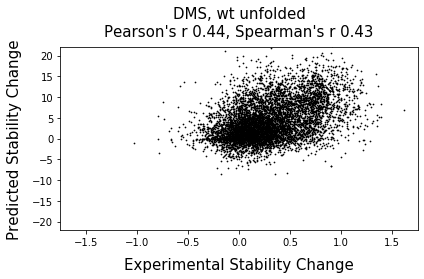

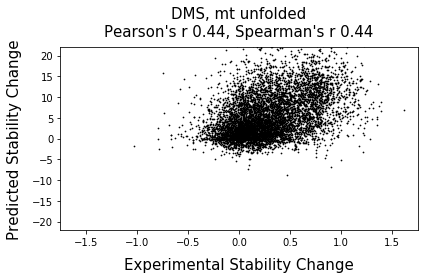

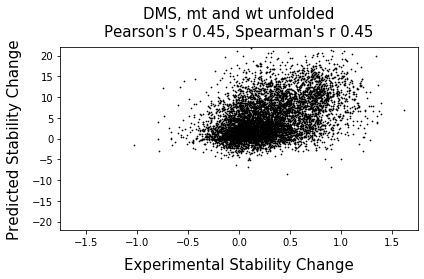

<IPython.core.display.Javascript object>

In [26]:
data_set = "dms"
data_set_title = "DMS"

helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=True
)
helpers.infer_probabilities_for_center_residues(
    ddg_data_dict, data_set, cavity_model_infer_net, DEVICE, EPS, is_wt=False
)
helpers.add_ddg_preds_with_unfolded_state(ddg_data_dict, data_set)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, wt unfolded",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt unfolded",
)

fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_wt_and_mt_phaistos_no_ds"],
    color="black",
    title=f"{data_set_title}, mt and wt unfolded",
)

##### Molecular dynamics

In [27]:
# Infer NLLs for WT and MT  in columns wt_nll_md and mt_nll_md
helpers.infer_molecular_dynamics_nlls(
    ddg_data_dict, "protein_g", DEVICE, EPS, cavity_model_infer_net, stride=STRIDE_MD
)
helpers.infer_molecular_dynamics_nlls(
    ddg_data_dict, "guerois", DEVICE, EPS, cavity_model_infer_net, stride=STRIDE_MD
)
helpers.infer_molecular_dynamics_nlls(
    ddg_data_dict, "dms", DEVICE, EPS, cavity_model_infer_net, stride=STRIDE_MD
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655


2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364


4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072


6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712


<IPython.core.display.Javascript object>

In [28]:
# Calculate DDgs
helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "protein_g")
helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "guerois")
helpers.add_ddg_preds_with_md_simulations(ddg_data_dict, "dms")

<IPython.core.display.Javascript object>

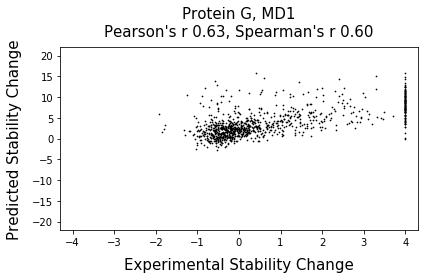

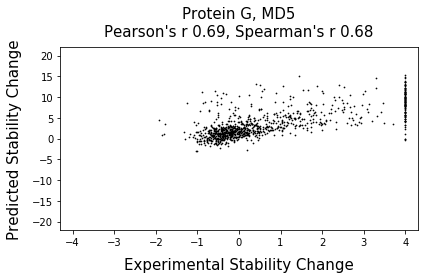

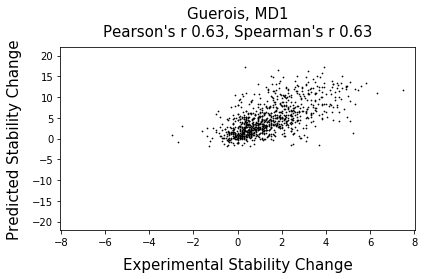

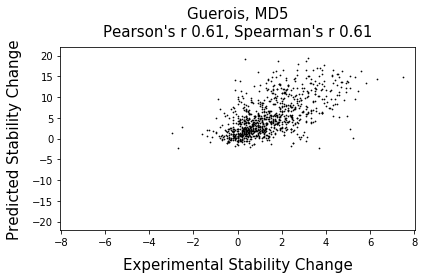

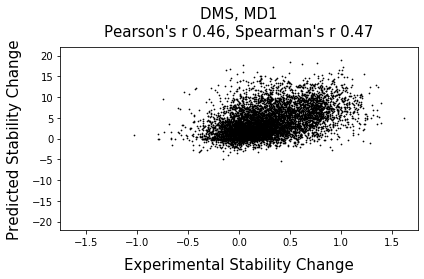

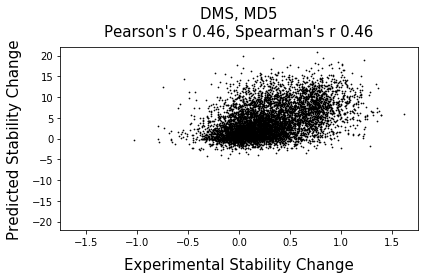

<IPython.core.display.Javascript object>

In [29]:
data_set = "protein_g"
data_set_title = "Protein G"
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD1",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD5",
)

data_set = "guerois"
data_set_title = "Guerois"
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD1",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD5",
)

data_set = "dms"
data_set_title = "DMS"
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_pdb_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD1",
)
fig, ax = scatter_pred_vs_true(
    ddg_data_dict[data_set]["ddg"],
    ddg_data_dict[data_set]["ddg_pred_md_phaistos_mt_and_wt_statistics_no_ds"],
    color="black",
    title=f"{data_set_title}, MD5",
)

In [30]:
# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_idp_statistics_no_ds"],
#     color="black",
#     title="protein G, MD2",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_wt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD3",
# )

# fig, ax = scatter_pred_vs_true(
#     ddg_data_dict["protein_g"]["ddg"],
#     ddg_data_dict["protein_g"]["ddg_pred_md_phaistos_mt_statistics_no_ds"],
#     color="black",
#     title="protein G, MD4",
# )


<IPython.core.display.Javascript object>

# Downstream model

### Performance without augmentation Vanilla

Define training dataloader and eval dataloaders

In [31]:
from cavity_model import DDGToTensor, DDGToTensorPhaistosAndMD

<IPython.core.display.Javascript object>

In [32]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensor
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict, DDGToTensor
)

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [33]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

<IPython.core.display.Javascript object>

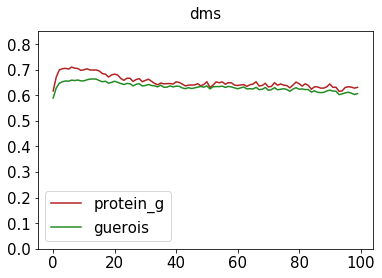

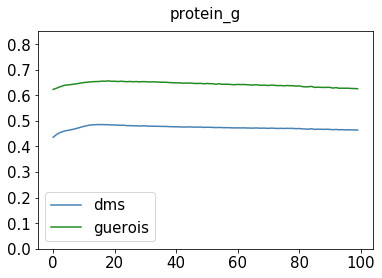

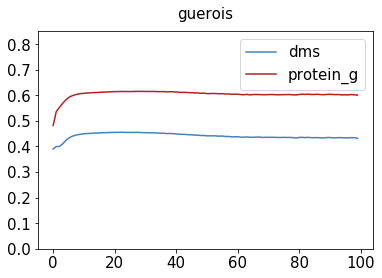

<IPython.core.display.Javascript object>

In [34]:
for key in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(key, pearsons_r_results_dict[key])

### Performance without augmentation With Phaistos and MD

In [35]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensorPhaistosAndMD
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict, DDGToTensorPhaistosAndMD
)

<IPython.core.display.Javascript object>

In [36]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

<IPython.core.display.Javascript object>

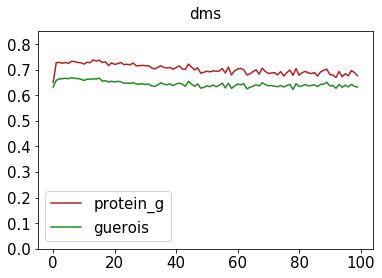

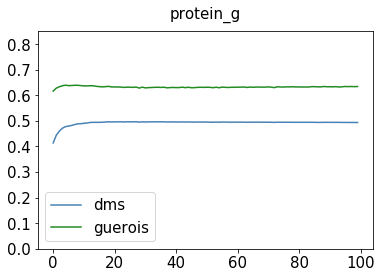

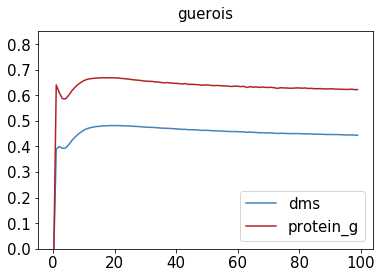

<IPython.core.display.Javascript object>

In [37]:
for key in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(key, pearsons_r_results_dict[key])

### Performance with augmentation Vanilla

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [38]:
ddg_data_dict_augmented = helpers.augment_with_reverse_mutation(ddg_data_dict)

<IPython.core.display.Javascript object>

Define training dataloader (augmented data) and eval dataloaders (original data)

In [39]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensor
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict_augmented, DDGToTensor
)

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [ ]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

In [ ]:
for key in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(key, pearsons_r_results_dict[key])

### Performance with augmentation With Phaistos and MD

In [ ]:
ddg_dataloaders_train_dict = helpers.get_ddg_training_dataloaders(
    ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG, DDGToTensorPhaistosAndMD
)
ddg_dataloaders_val_dict = helpers.get_ddg_validation_dataloaders(
    ddg_data_dict_augmented, DDGToTensorPhaistosAndMD
)

In [ ]:
pearsons_r_results_dict = helpers.train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

In [ ]:
for key in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(key, pearsons_r_results_dict[key])